# The file is an analysis of the preliminary $\alpha_{\textrm{CE}}$ variation run following the methods in the tutorial from the compas repo.

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings
import pickle

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
matplotlib.rc('font', **{'family': 'sans-serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rc('font', family='serif')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_64423/2697254037.py:35: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


# 1. Create Compas data objects
##  a) Condense the each of the batch's outputs into one h5 file
Function that combines all of the h5 files from each batch. It will write and return the complete h5 file

In [14]:
def condense_h5s(output_dir):

    index = 0 # A useful variable for indexing through the files in the output directory

    # Iterate through the files in the output directory
    for dir in os.listdir(output_dir):
        
        # Make sure that the directories are from the batches
        if dir[0:5] == 'batch':
            batch_num = dir [-1]
            f_h5 = h5.File(output_dir + '/batch_' + batch_num + '/batch_' + batch_num + '.h5', 'r')
            
            # If it's the first batch directory, create an h5 file and copy the first batch's contents into it
            if index == 0:
                # Create an h5 file to put all of the batch's h5 files in
                complete_h5 = h5.File(output_dir + '/complete.h5', 'w')

                # Create and copy the first batch's h5 file into the complete_h5 file
                # DCOs = complete_h5.create_group('BSE_Double_Compact_Objects')
                for group in f_h5.keys():
                    # complete_h5.create_group(group)
                    f_h5.copy(f_h5[group], complete_h5)
                
                DCOs = complete_h5['BSE_Double_Compact_Objects']
                CEs = complete_h5['BSE_Common_Envelopes']
                RLOFs = complete_h5['BSE_RLOF']
                SNs = complete_h5['BSE_Supernovae']
                SPs = complete_h5['BSE_System_Parameters']
                RDs = complete_h5['Run_Details']
                
            # If it's not the first directory, append the new data to each group in the complete h5 file
            else:
                # Append new data to it
                for key in DCOs.keys():
                    DCOs[key].resize((DCOs[key].shape[0] + f_h5['BSE_Double_Compact_Objects'][key].shape[0]), axis=0)
                    DCOs[key][-f_h5['BSE_Double_Compact_Objects'][key].shape[0]:] = f_h5['BSE_Double_Compact_Objects'][key]
                
                for key in CEs.keys():
                    CEs[key].resize((CEs[key].shape[0] + f_h5['BSE_Common_Envelopes'][key].shape[0]), axis=0)
                    CEs[key][-f_h5['BSE_Common_Envelopes'][key].shape[0]:] = f_h5['BSE_Common_Envelopes'][key]
                
                for key in RLOFs.keys():
                    RLOFs[key].resize((RLOFs[key].shape[0] + f_h5['BSE_RLOF'][key].shape[0]), axis=0)
                    RLOFs[key][-f_h5['BSE_RLOF'][key].shape[0]:] = f_h5['BSE_RLOF'][key]
                
                for key in SNs.keys():
                    SNs[key].resize((SNs[key].shape[0] + f_h5['BSE_Supernovae'][key].shape[0]), axis=0)
                    SNs[key][-f_h5['BSE_Supernovae'][key].shape[0]:] = f_h5['BSE_Supernovae'][key]
                
                for key in SPs.keys():
                    SPs[key].resize((SPs[key].shape[0] + f_h5['BSE_System_Parameters'][key].shape[0]), axis=0)
                    SPs[key][-f_h5['BSE_System_Parameters'][key].shape[0]:] = f_h5['BSE_System_Parameters'][key]
                
                for key in RDs.keys():
                    RDs[key].resize((RDs[key].shape[0] + f_h5['Run_Details'][key].shape[0]), axis=0)
                    RDs[key][-f_h5['Run_Details'][key].shape[0]:] = f_h5['Run_Details'][key]

            index+=1 # Update the index
            f_h5.close() # Close the batch file

    complete_h5.close() # Close the complete h5 file
    return output_dir + '/complete.h5'

Condense all .h5 file outputs for the common envelope alpha values

In [15]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = condense_h5s('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_alpha_CE_beta/alpha_CE_' + alpha + '_beta_' + beta)

*** To use if the h5 files have already been condensed! ***

In [4]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = '/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_alpha_CE_beta/alpha_CE_' + alpha + '_beta_' + beta + '/complete.h5'

## b) Create COMPASData objects for each of the $\alpha_{\textrm{CE}}$ and $\beta$ values

In [5]:
# For now, assume all the defaults and just set the paths for each value
data = {} # 2D dictionary in which the first dimension is the alpha CE value and the second is the beta value
for alpha_index, alpha_val in enumerate(alpha_vals):
    data[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        data[alpha_val][beta_val] = ClassCOMPAS.COMPASData(path=condensed_paths[alpha_val][beta_val])

ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and option

In [6]:
counter = 0
for alpha_val, beta_dict in data.items():
    for beta_val, compas_data in beta_dict.items():
        data[alpha_val][beta_val].Mlower = 5
        data[alpha_val][beta_val].Mupper = 150
        data[alpha_val][beta_val].binaryFraction = 1.0
        data[alpha_val][beta_val].setGridAndMassEvolved()
        data[alpha_val][beta_val].Amin = 0.01
        data[alpha_val][beta_val].Mupper = 1000
        data[alpha_val][beta_val].setCOMPASData()
        # data[alpha_val][beta_val].setCOMPASDCOmask(types='BBH')

    print('Finished ', counter, 'set of beta values')
    counter+=1


Finished  0 set of beta values
Finished  1 set of beta values
Finished  2 set of beta values
Finished  3 set of beta values


Make a pickle file to put all the compas_data files in. This is helpful because the method ``` setGridAndMassEvolved() ``` is very time consuming

In [7]:
with open('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/compas_objects/alpha_CE_beta.pkl', 'wb') as f:
    x = pickle.dump(data, f)

If the pickle file has already been written, we can use the following cell! :)

In [8]:
with open('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/compas_objects/alpha_CE_beta.pkl', 'rb') as f:
    data = pickle.load(f)

## c) Check the number of each type of system in the runs

In [36]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BBH', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BBH systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BHNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BHNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

Number of BBH systems at alpha_CE = 0.1 and beta = 0.25 61805
Number of BBH systems at alpha_CE = 0.1 and beta = 0.5 61020
Number of BBH systems at alpha_CE = 0.1 and beta = 0.75 102579
Number of BBH systems at alpha_CE = 0.5 and beta = 0.25 122996
Number of BBH systems at alpha_CE = 0.5 and beta = 0.5 137105
Number of BBH systems at alpha_CE = 0.5 and beta = 0.75 149897
Number of BBH systems at alpha_CE = 2.0 and beta = 0.25 196674
Number of BBH systems at alpha_CE = 2.0 and beta = 0.5 165740
Number of BBH systems at alpha_CE = 2.0 and beta = 0.75 157426
Number of BBH systems at alpha_CE = 10.0 and beta = 0.25 71813
Number of BBH systems at alpha_CE = 10.0 and beta = 0.5 97340
Number of BBH systems at alpha_CE = 10.0 and beta = 0.75 137663

Number of BNS systems at alpha_CE = 0.1 and beta = 0.25 263
Number of BNS systems at alpha_CE = 0.1 and beta = 0.5 690
Number of BNS systems at alpha_CE = 0.1 and beta = 0.75 1000
Number of BNS systems at alpha_CE = 0.5 and beta = 0.25 105
Number o

In [16]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASData()

# 3. Plot formation rate as a function of metallicity

Some functions that may be helpful

In [339]:
def bin_data(data, rates = None, num_bins=100):

    # The lower bounds for each bin
    bin_lower = np.linspace(min(data), max(data), num=num_bins)

    # The "width" of the bin
    dx = bin_lower[1] - bin_lower[0]

    # The 2d array of the bins
    x = [[] for j in range(num_bins)]
    
    # Check if the data has rates attributed to each x value
    if rates is None:

        # Sort each data point into its bin
        index = 0
        for pt in data:
            for lower in bin_lower:
                if lower <= pt and pt < lower + dx:
                    x[index].append(pt)
                    index=0
                    break
                else:
                    index+=1
    else:
        
        # Sort each data point and rate into its bin
        binned_rates = [[] for j in range(num_bins)]

        for data_index, pt in enumerate(data):
            for bin_index, lower in enumerate(bin_lower):
                if lower <= pt and pt < lower + dx:
                    x[bin_index].append(pt)
                    binned_rates[bin_index].append(rates[data_index])

                    break

    # Return all the data
    bins = bin_lower + 0.5*dx
    if rates is None:
        return bins, x
    else:
        return bins, x, binned_rates

def sum1d(data):
    summed = np.zeros(len(data))
    for index, col in enumerate(data):
        summed[index] = np.sum(col)

    return summed

def avg1d(data):
    avged = np.zeros(len(data))
    for index, col in enumerate(data):
        avged[index] = np.average(col)

    return avged

def get_formation_rate_total(binned_log10metallicities, binned_mass_per_Z):
    formation_rate_total = np.zeros(len(binned_log10metallicities))
    
    for index in range(len(formation_rate_total)):
        if len(binned_mass_per_Z) == 0:
            formation_rate_total[index] = 0
        else:
            formation_rate_total[index] = np.divide(len(binned_log10metallicities[index]), np.sum(binned_mass_per_Z[index]))
    
    return formation_rate_total
    

## a) All the system types

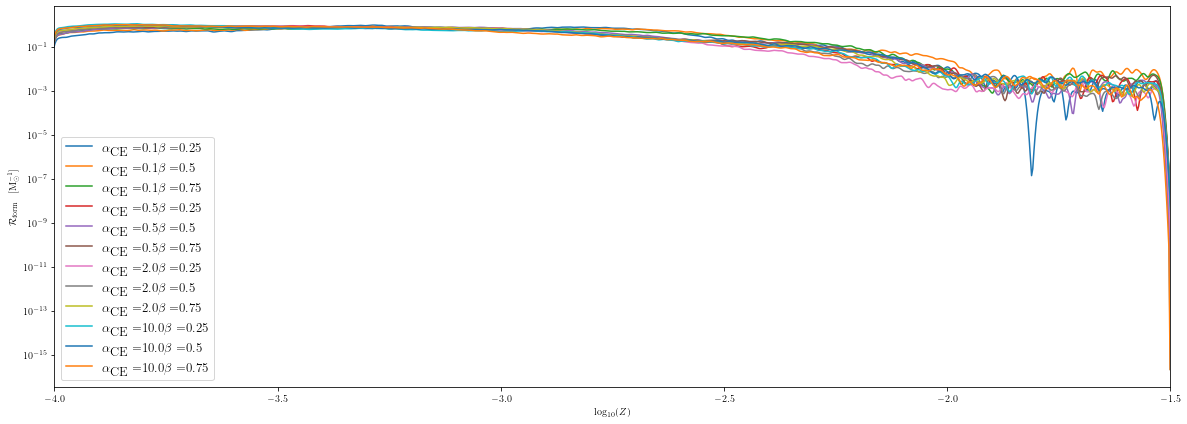

In [29]:
def plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type, bw=0.02):
    """
    This function plots the formation rate as a function of Z for the given data and DCO type. It will iterate over given
    alpha and beta values and plot the formation rates of their runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    bw: float
        the bandwidth for the KDE that will be calculated for the plot
    """

    # Declare figure
    fig = plt.figure(figsize=(20, 9))
    plt.yscale('log')

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            # Get the current compas object
            model_data = data[alpha_val][beta_val]

            # Set the mask to the given DCO type
            model_data.setCOMPASDCOmask(types=dco_type)

            # Get the metallicities of the systems and declare an empty formationRate array
            metallicities = model_data.metallicitySystems[model_data.DCOmask]
            formationRate = np.zeros(len(metallicities))

            # Set the numerator for the formation rate to the number of systems as each metallicity
            for nrZ, Z in enumerate(metallicities):
                if Z in model_data.metallicityGrid:
                    maskZ = (metallicities == Z)                    # mask for the specific metallicity
                    formationRate[nrZ] = len(metallicities[maskZ])  # numerator is the number of systems as metallicity Z
                else:
                    formationRate[nrZ] = 0

            # Get the formation rate by dividing the number of systems at each Z by the total mass evolved at that Z
            maskZgridinZlist = np.in1d(metallicities, model_data.metallicityGrid)       # mask for making sure the grid Z metallicities are in the run metallicities
            maskZlistinZgrid = np.in1d(model_data.metallicityGrid, metallicities)       # mask for making sure the run metallicities are in the the grid Z metallicities
            formationRate[maskZgridinZlist] = np.divide(formationRate[maskZgridinZlist], model_data.totalMassEvolvedPerZ[maskZlistinZgrid]) + 0

            # Calculate KDE
            mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=bw).fit(np.log10(metallicities), weights=formationRate).evaluate()

            # Label and bound axes
            plt.xlabel(r'$\log_{10}(Z)$', fontsize=20)
            plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=20)
            plt.xlim([-4, -1.5])

            # Adjust tick size
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            # Plot KDE
            plt.plot(mass_per_z_axis, mass_per_z_kde, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

    # Include a legend
    plt.legend(loc='lower left', prop={'size': 13})
    
    # Display the plot
    plt.show()

# Plot formation rate all dcos
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, 'all')

In [108]:
print(np.sum(data['0.1']['0.25'].totalMassEvolvedPerZ))

118411062.12943381


## b) BBH

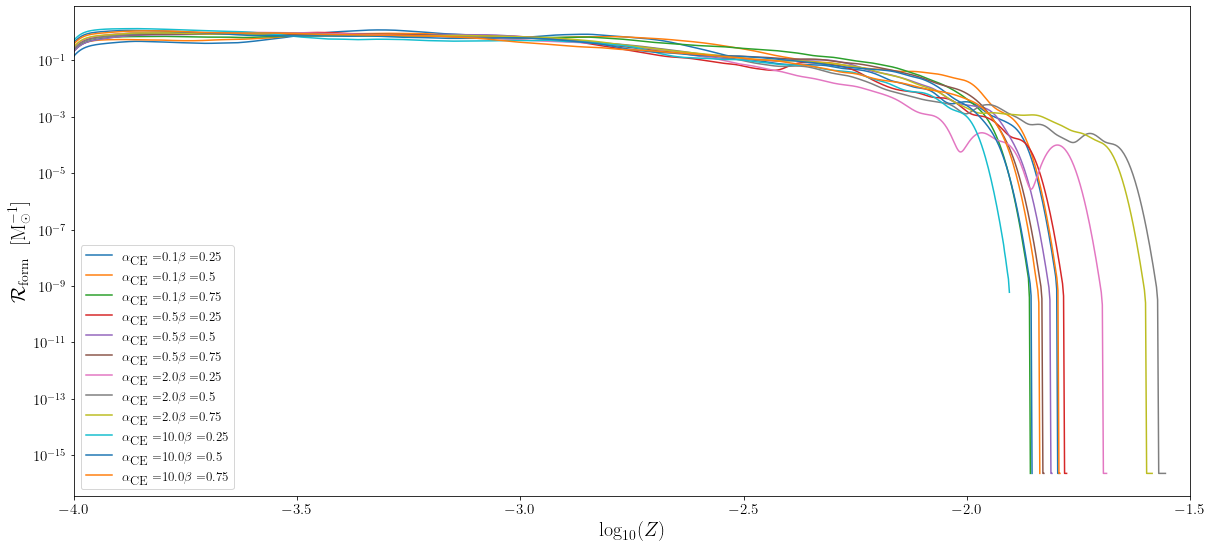

In [57]:
# Plot formation rate for BBHs
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, 'BBH', bw=0.02)

## c) BHNS

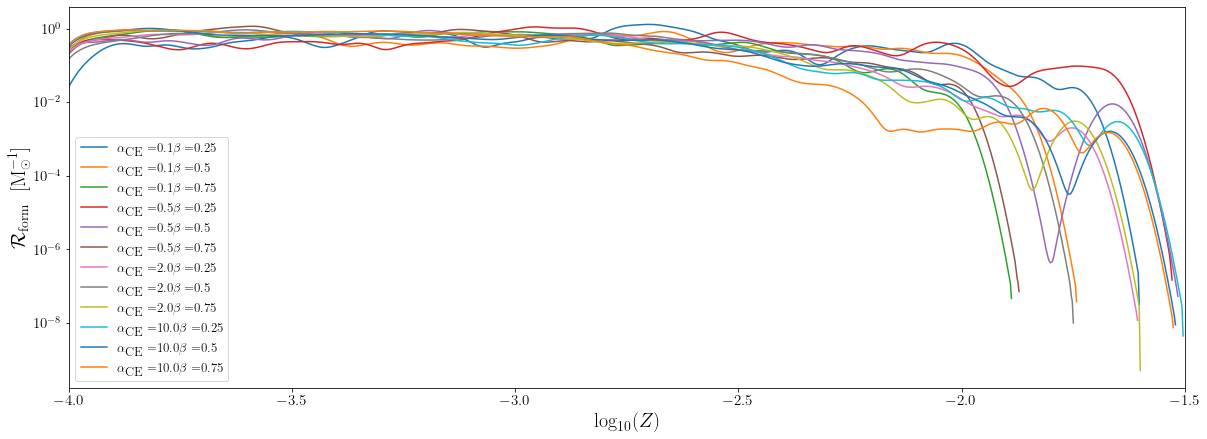

In [58]:
# Plot formation rate for BHNSs
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, 'BHNS', bw=0.03)

# d) BNS

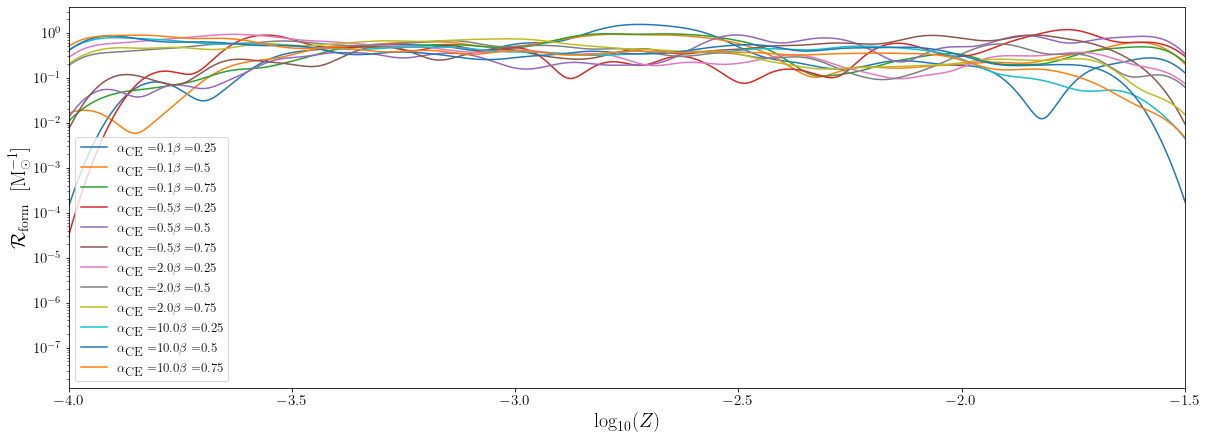

In [59]:
# Plot formation rate for BNSs
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, 'BNS', bw=0.05)

In [ ]:
def plot_formation_rate_per_Z(data, alpha_vals, beta_vals, dco_type, bw=0.02):
    """
    This function plots the formation rate as a function of Z for the given data and DCO type. It will iterate over given
    alpha and beta values and plot the formation rates of their runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    bw: float
        the bandwidth for the KDE that will be calculated for the plot
    """

    # Declare figure
    fig = plt.figure(figsize=(20, 9))
    plt.yscale('log')

    # Iterate over the 2D dictionary and plot the formation rate as a function of Z for each of the alpha_CE-beta combinations
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            # Get the current compas object
            model_data = data[alpha_val][beta_val]

            # Set the mask to the given DCO type
            model_data.setCOMPASDCOmask(types=dco_type)

            # Get the metallicities of the systems and declare an empty formationRate array
            metallicities = model_data.metallicitySystems[model_data.DCOmask]
            formationRate = np.zeros(len(metallicities))

            # Set the numerator for the formation rate to the number of systems as each metallicity
            for nrZ, Z in enumerate(metallicities):
                if Z in model_data.metallicityGrid:
                    maskZ = (metallicities == Z)                    # mask for the specific metallicity
                    formationRate[nrZ] = len(metallicities[maskZ])  # numerator is the number of systems as metallicity Z
                else:
                    formationRate[nrZ] = 0

            # Get the formation rate by dividing the number of systems at each Z by the total mass evolved at that Z
            maskZgridinZlist = np.in1d(metallicities, model_data.metallicityGrid)       # mask for making sure the grid Z metallicities are in the run metallicities
            maskZlistinZgrid = np.in1d(model_data.metallicityGrid, metallicities)       # mask for making sure the run metallicities are in the the grid Z metallicities
            formationRate[maskZgridinZlist] = np.divide(formationRate[maskZgridinZlist], model_data.totalMassEvolvedPerZ[maskZlistinZgrid]) + 0

            # Calculate KDE
            mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=bw).fit(np.log10(metallicities), weights=formationRate).evaluate()

            # Label and bound axes
            plt.xlabel(r'$\log_{10}(Z)$', fontsize=20)
            plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=20)
            plt.xlim([-4, -1.5])

            # Adjust tick size
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

            # Plot KDE
            plt.plot(mass_per_z_axis, mass_per_z_kde, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

    # Include a legend
    plt.legend(loc='lower left', prop={'size': 13})
    
    # Display the plot
    plt.show()

# Plot formation rate all dcos
plot_formation_rate_per_Z(data, alpha_vals, beta_vals, 'all')

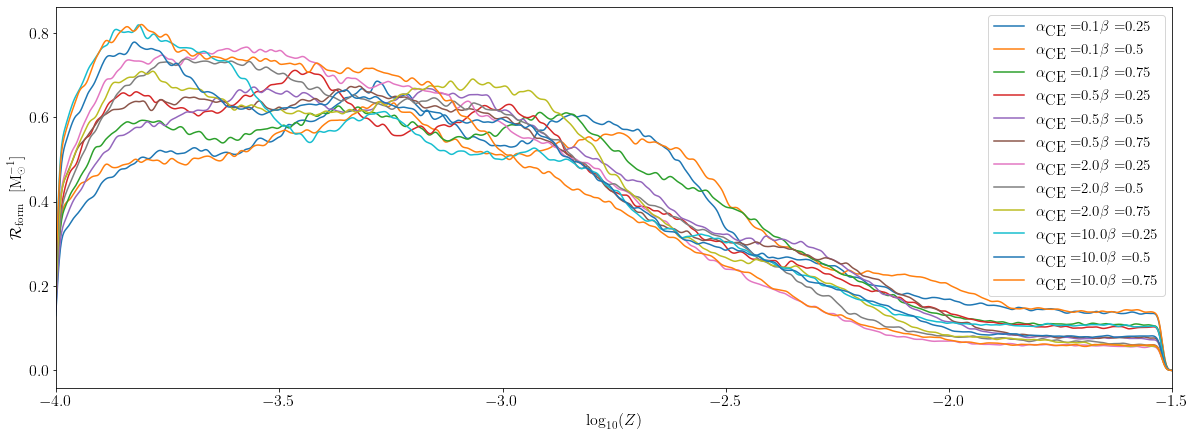

In [283]:
# Declare figure
fig = plt.figure(figsize=(20, 7))

for alpha_val in alpha_vals:
    for beta_val in beta_vals:

        # Take the log of the metallicity grid
        log10metallicities = np.log10(data[alpha_val][beta_val].metallicityGrid)

        # Calculate a KDE with the weights of the metallicities being the total mass evolved at the given Z
        mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=0.007).fit(log10metallicities, weights=data[alpha_val][beta_val].totalMassEvolvedPerZ).evaluate()

        # Label and bound axes
        plt.xlabel(r'$\log_{10}(Z)$')
        plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$')
        plt.xlim([-4, -1.5])

        # Plot KDE
        plt.plot(mass_per_z_axis, mass_per_z_kde, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

plt.legend(loc='upper right', prop={'size': 15})

# 3. Get the detection rates

Import a function that will quickly calculate and return the probability density function (PDF) for a given distribution

## a) NSNS

In [9]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
dco_type        = "BNS"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

In [ ]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_39131/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  233484490.74612236 solMass
Average_SF_mass_needed =  234363132.61987862 solMass
Average_SF_mass_needed =  234271823.10720003 solMass
Average_SF_mass_needed =  234512590.03182808 solMass
Average_SF_mass_needed =  234415239.7778611 solMass
Average_SF_mass_needed =  234028071.5593216 solMass
Average_SF_mass_needed =  234690228.86408833 solMass
Average_SF_mass_needed =  233041027.23372015 solMass
Average_SF_mass_needed =  234725099.81108996 solMass
Average_SF_mass_needed =  234035443.7801953 solMass
Average_SF_mass_needed =  234507397.4275715 solMass
Average_SF_mass_needed =  234682112.92394814 solMass


In [ ]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

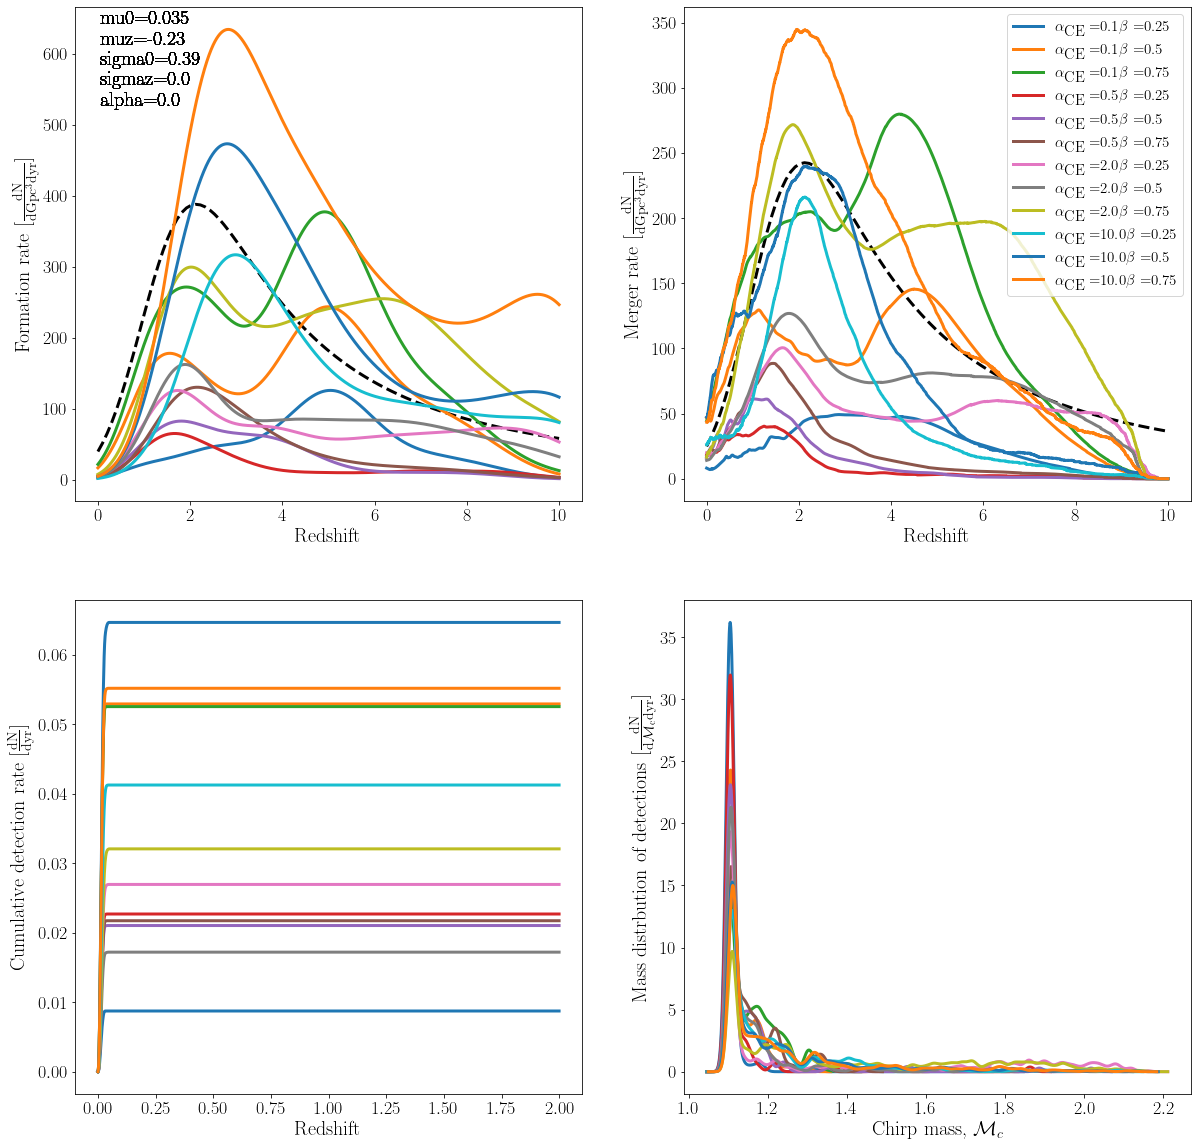

In [237]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Calculate and scare the SFR to plot on the formation and merger rate plots
sfr_redshifts = np.linspace(0, 10, num=100)
sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)
formation_rate_sfr = 4 * sfr * 10**(-6)
merger_rate_sfr =  2.5 * sfr * 10**(-6)

# Plot SFRs
axes[0,0].plot(sfr_redshifts, formation_rate_sfr, color='black', lw=lw, linestyle='dashed')
axes[0,1].plot(sfr_redshifts, merger_rate_sfr, color='black', lw=lw, linestyle='dashed')

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw=0.01).fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)
                # axes[1,1].set_xlim([1.09, 1.16])        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

## b) BHNS

In [245]:
dco_type        = "BHNS"

In [246]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_39131/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  234717863.50518775 solMass
Average_SF_mass_needed =  234466813.17535603 solMass
Average_SF_mass_needed =  235019107.38015997 solMass
Average_SF_mass_needed =  234587441.27685317 solMass
Average_SF_mass_needed =  235610508.70500967 solMass
Average_SF_mass_needed =  236336198.8003492 solMass
Average_SF_mass_needed =  235594145.28961614 solMass
Average_SF_mass_needed =  233568517.64815742 solMass
Average_SF_mass_needed =  232595998.4938003 solMass
Average_SF_mass_needed =  236164605.28594124 solMass
Average_SF_mass_needed =  233216961.22905713 solMass
Average_SF_mass_needed =  234437384.45341814 solMass


In [247]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

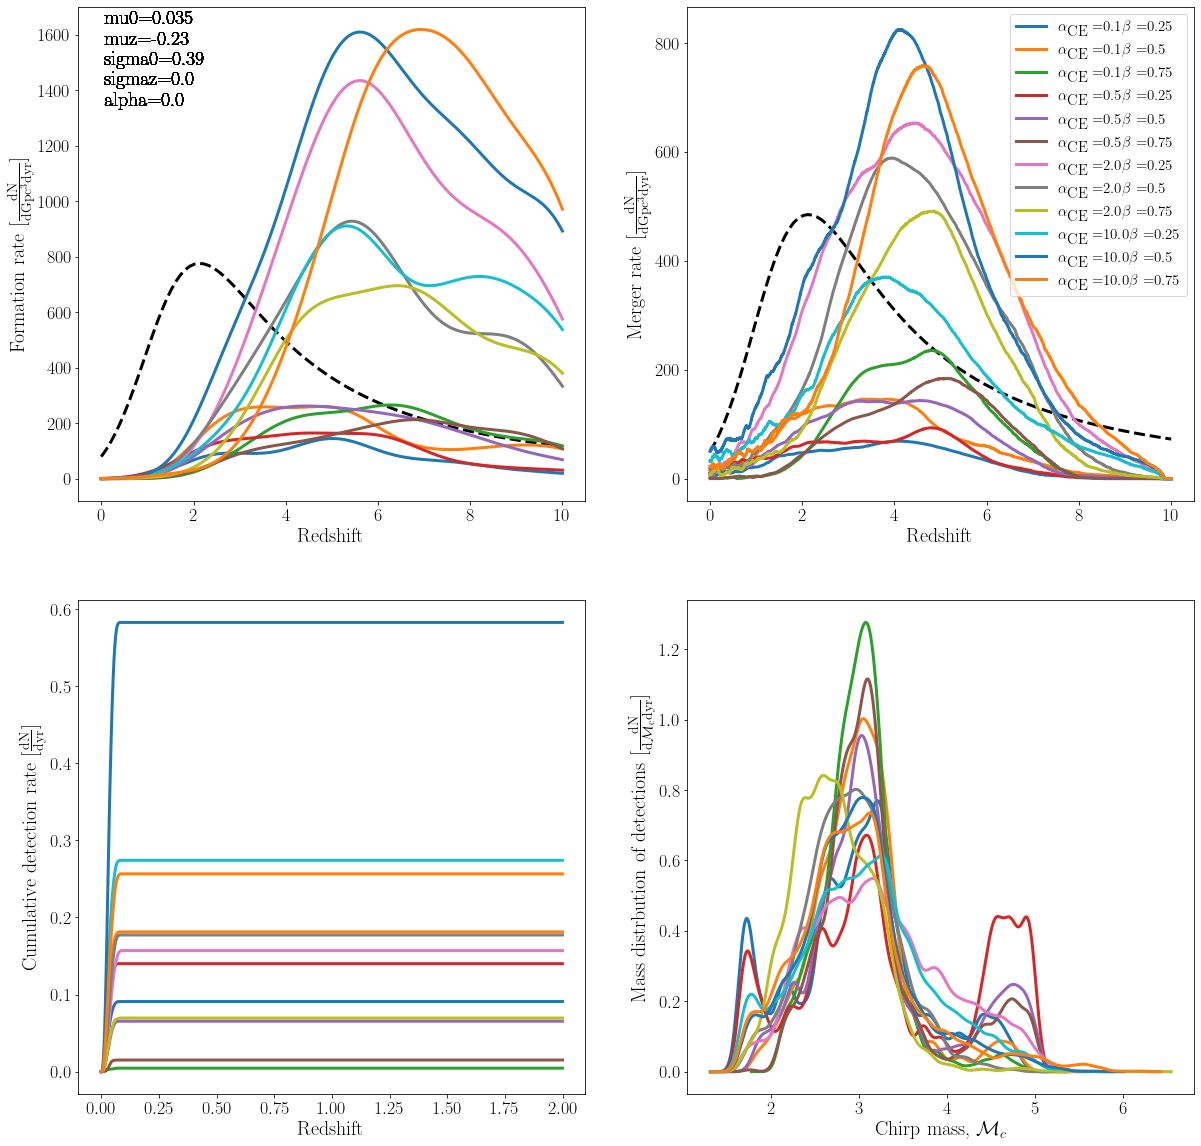

In [248]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Calculate and scare the SFR to plot on the formation and merger rate plots
sfr_redshifts = np.linspace(0, 10, num=100)
sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)
formation_rate_sfr = 8 * sfr * 10**(-6)
merger_rate_sfr =  5 * sfr * 10**(-6)

# Plot SFRs
axes[0,0].plot(sfr_redshifts, formation_rate_sfr, color='black', lw=lw, linestyle='dashed')
axes[0,1].plot(sfr_redshifts, merger_rate_sfr, color='black', lw=lw, linestyle='dashed')

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$ \beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw=0.07).fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

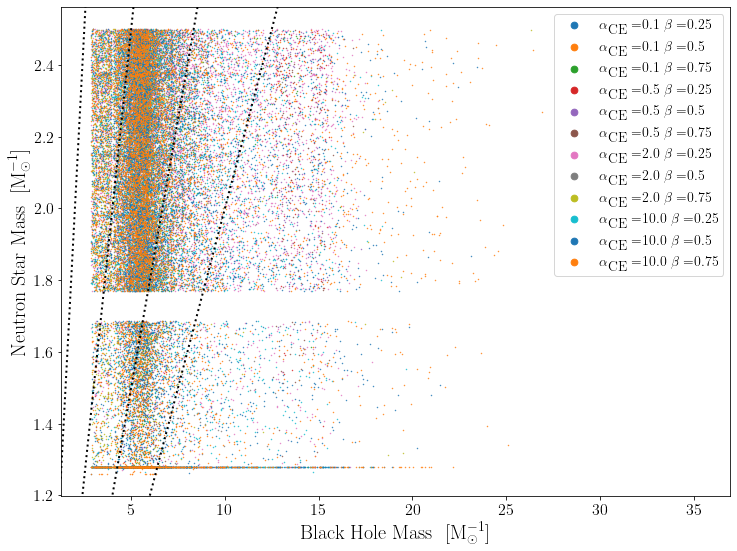

In [102]:
def plot_bhns_masses(data, alpha_vals, beta_vals):
    """
    This function plots the masses of black holes and neutron stars for BHNS mergers in given data. It will iterate over given
    alpha_CE and beta values and plot the formation rates of their BHNS runs' results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    """

    # Declar figure
    plt.figure(figsize=(12, 9))

    # Iterate over given alpha_CE and beta values
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            model_data = data[alpha_val][beta_val] # the data

            # Get the important BSE values
            stellar_type_1, stellar_type_2, hubble_flag, mass_1, mass_2 = \
                        model_data.get_COMPAS_variables("BSE_Double_Compact_Objects", ["Stellar_Type(1)", "Stellar_Type(2)", "Merges_Hubble_Time", "Mass(1)", "Mass(2)"])
            
            # Mask for BHNS systems
            bhns_mask = np.logical_or(np.logical_and(stellar_type_1 == 13, stellar_type_2==14), np.logical_and(stellar_type_1 == 14, stellar_type_2==13))
            
            # Get the data for BHNS systems only
            stellar_type_1, stellar_type_2, hubble_flag, mass_1, mass_2 = \
                        stellar_type_1[bhns_mask], stellar_type_2[bhns_mask], hubble_flag[bhns_mask], mass_1[bhns_mask], mass_2[bhns_mask]

            # Flags for the neutron stars
            ns1_flag = np.logical_and(stellar_type_1 == 13, hubble_flag==1)     # primary
            ns2_flag = np.logical_and(stellar_type_2 == 13, hubble_flag==1)     # secondary

            # Get the masses
            ns1_mass = mass_1[ns1_flag]                                         # primary
            ns2_mass = mass_2[ns2_flag]                                         # secondary

            # Combine to get the entire list of neutron star masses
            ns_mass = np.concatenate((ns1_mass, ns2_mass), axis=0)

            # Flags for black holes
            bh1_flag = np.logical_and(stellar_type_1 == 14, hubble_flag==1)     # primary
            bh2_flag = np.logical_and(stellar_type_2 == 14, hubble_flag==1)     # secondary

            # Get the masses 
            bh1_mass = mass_1[bh1_flag]                                         # primary
            bh2_mass = mass_2[bh2_flag]                                         # secondary

            # Combine to get the entire list of black hole masses
            bh_mass = np.concatenate((bh1_mass, bh2_mass), axis=0)

            # Plot the data
            plt.scatter(bh_mass, ns_mass, s=0.2, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

    # Plot dotted lines for a couple of mass ratios
    ax = plt.gca()                  # current axis
    x_lims = ax.get_xlim()          # x limits of plot
    y_lims = ax.get_ylim()          # y limits of plot
    q_list = [1, 0.5, 0.3, 0.2]     # list of mass ratios to plot

    # Iterate through and plot each q value
    for q_val in q_list:
        y_q = q_val * np.array(x_lims)
        plt.plot(x_lims, y_q, c='k', lw=2, linestyle =':')
        plt.annotate()

    # Label axes
    plt.xlabel(r'Black Hole Mass$   \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=20)
    plt.ylabel(r'Neutron Star Mass$   \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=20)

    # Include legend
    plt.legend(loc='upper right',  prop={'size': 14},  markerscale=15)

    # Adjust tick fontsize
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Set limits of plot
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)

    # Display the plot
    plt.show()

plot_bhns_masses(data, alpha_vals, beta_vals)

## c) BHBH

In [8]:
dco_type        = "BBH"

In [9]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26694/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  235286927.44397902 solMass
Average_SF_mass_needed =  234656361.9262687 solMass
Average_SF_mass_needed =  235253414.42953998 solMass
Average_SF_mass_needed =  234847495.8294083 solMass


: 

: 

In [ ]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

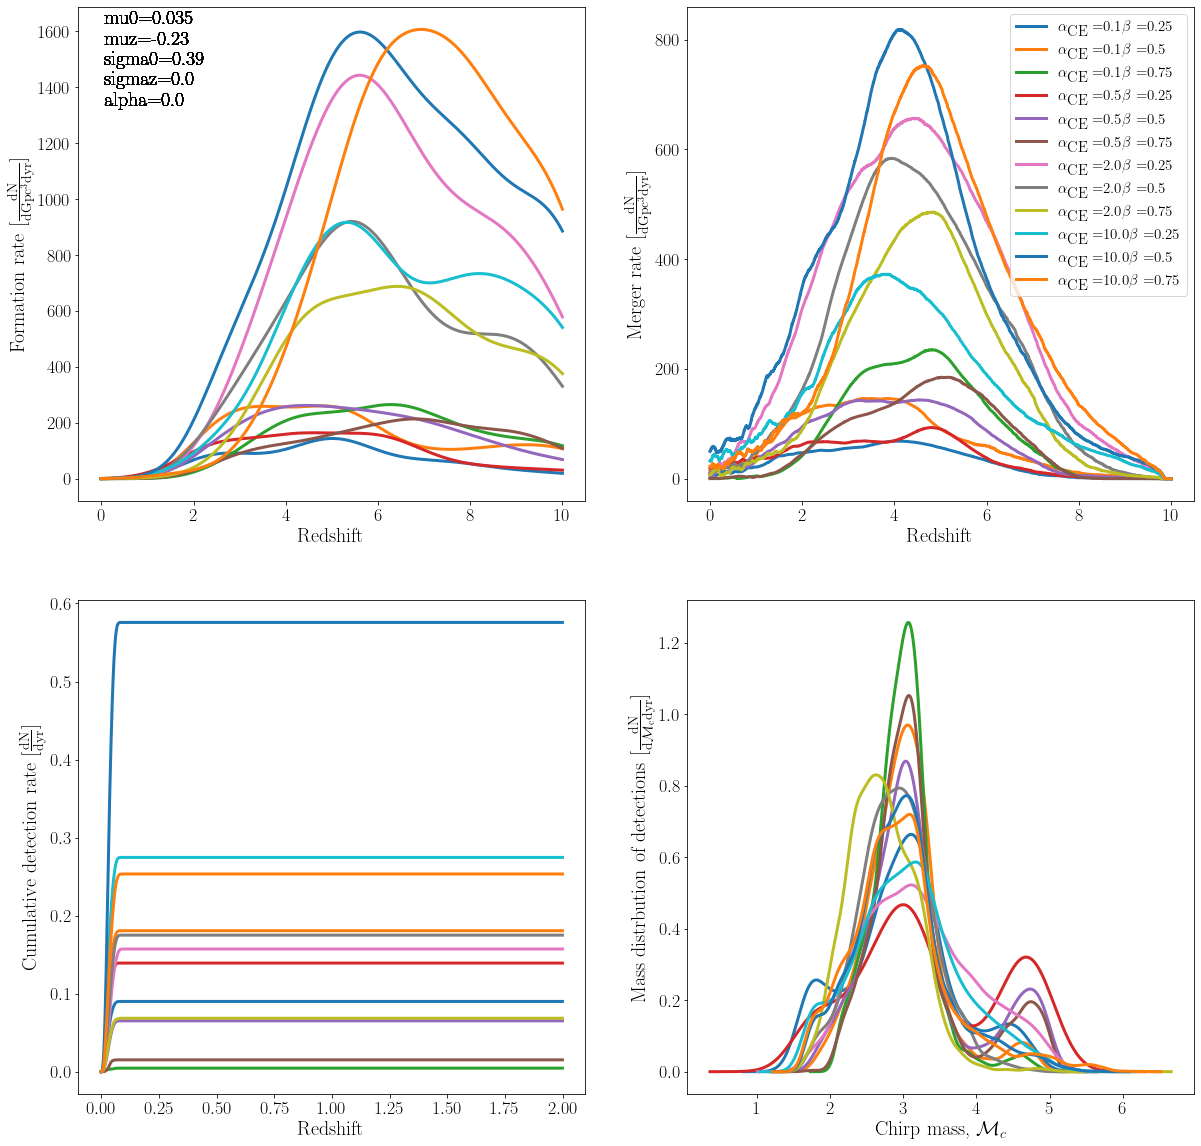

In [ ]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw='silverman').fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

# 3. Metallicity-Delay Time Scatter Plots

## a) BNS

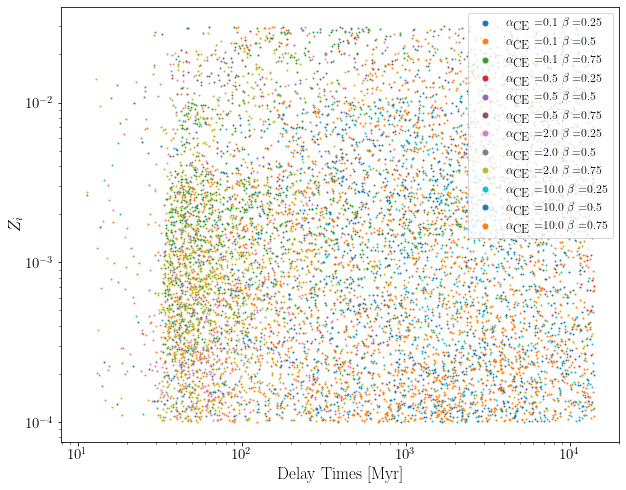

In [85]:
def plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, dco_type):
    """
    This function plots the initial metallicities and time delays for BHNS mergers in given data. It will iterate over given
    alpha_CE and beta values and plot the initia metallicity and time delay for each run's results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension
    
    dco_type: str
        one of 'all', 'BBH', 'BHNS', or 'BNS'; the DCO type that we wish to look at.

    """

    # Declare figure
    plt.figure(figsize=(10, 8))

    # Declare axis scales
    plt.yscale("log")  
    plt.xscale("log")

    # Iterate across alpha_CE-beta grid and plot the delay times versus metallicities
    for alpha_val in alpha_vals:
            for beta_val in beta_vals:

                model_data = data[alpha_val][beta_val] # the data
                model_data.setCOMPASDCOmask(dco_type)

                # Get the important BSE values
                time, coalescence_time, dco_seeds = \
                            model_data.get_COMPAS_variables("BSE_Double_Compact_Objects", ["Time", "Coalescence_Time", "SEED"])
                
                # Get the initial metallicities
                Zi, seeds = \
                            model_data.get_COMPAS_variables("BSE_System_Parameters", ["Metallicity@ZAMS(1)", "SEED"])
                
                # Mask for being a DCO
                dco_mask = np.isin(seeds, dco_seeds)

                # Get the DCO initial metallicities
                Zi = Zi[dco_mask]

                # Calculate the time delay for all DCOs
                t_delay = time + coalescence_time

                # Get the time delays and initial metallicities for the given DCO type
                t_delay = t_delay[model_data.DCOmask]
                Zi = Zi[model_data.DCOmask]

                # Plot the time delay and initial metallicities
                plt.scatter(t_delay, Zi, s=1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

    # Label the axes
    plt.xlabel('Delay Times [Myr]', fontsize=17)
    plt.ylabel(r'$Z_i$', fontsize=17)

    # Adjust tick size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Insert a legend
    plt.legend(loc='upper right',  prop={'size': 12}, markerscale=5)

    # Show the figure!
    plt.show()


plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, 'BNS')

## b) BHNS

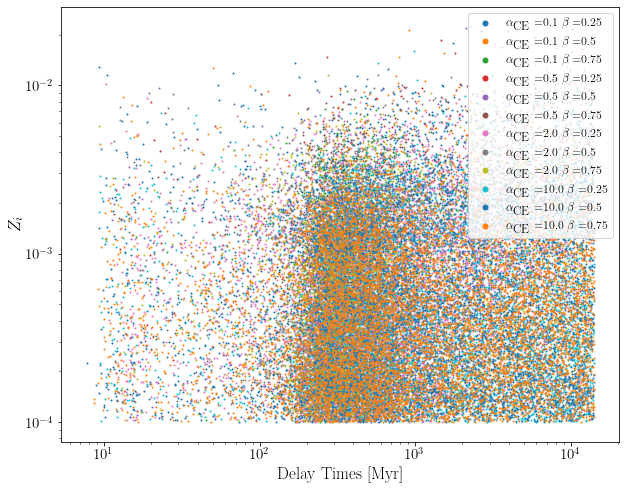

In [86]:
plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, 'BHNS')

## c) BBH

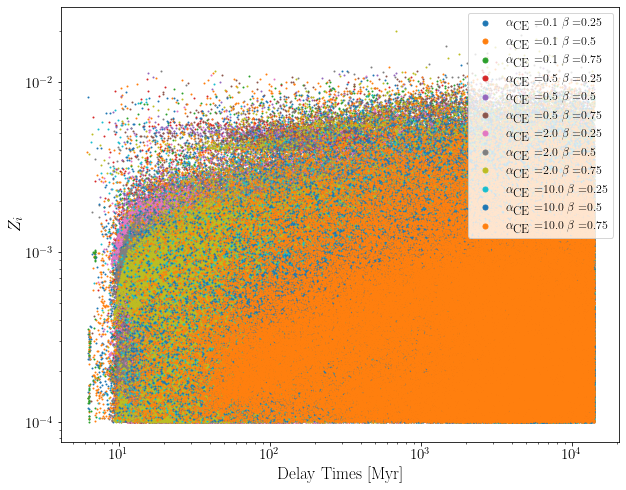

In [87]:
plot_metallicityVSdelay_times(data, alpha_vals, beta_vals, 'BBH')

# Formation rates VS $t_\textrm{delay}$

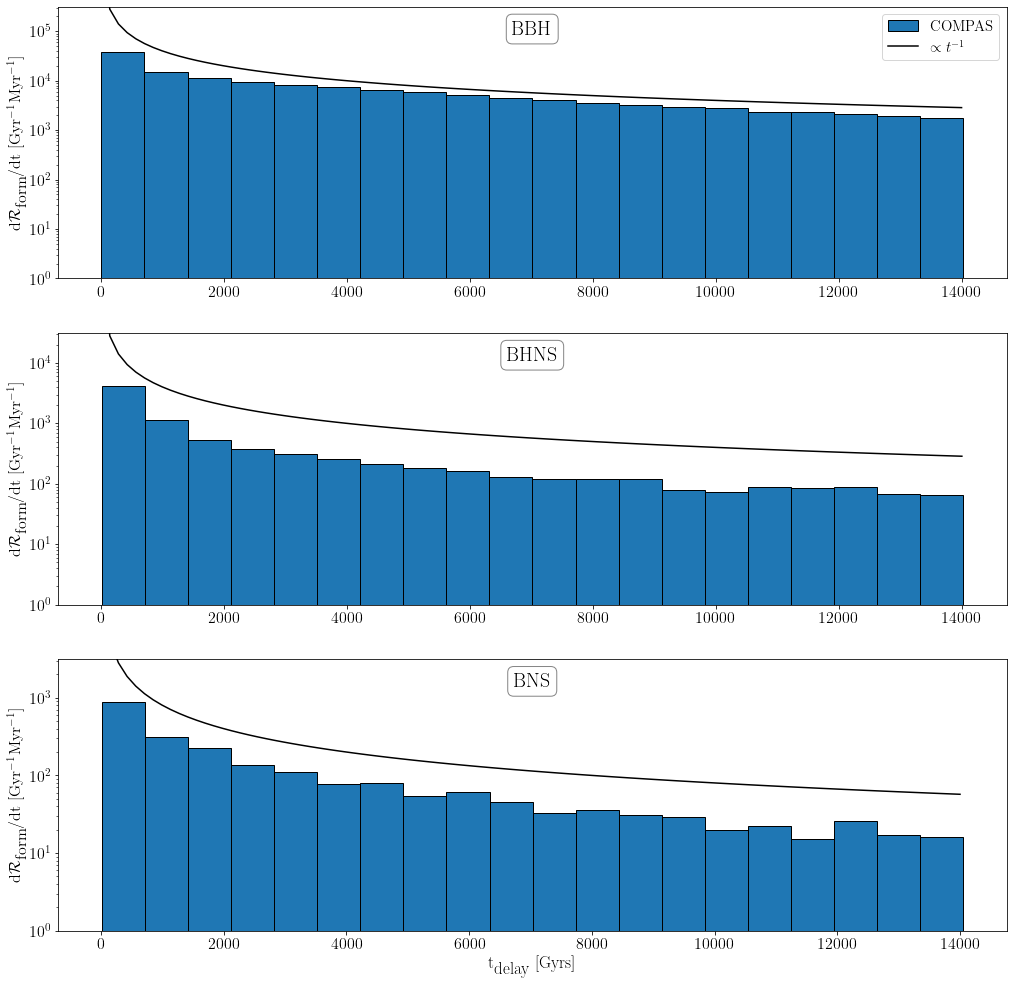

In [119]:
# Adjust fontsize
plt.rcParams['font.size'] = '16'

# Declare figure and subplots
fig, axes = plt.subplots(3, figsize=(17,17))

# Dict of the different data we wish to plot
dco_types = ['BBH', 'BHNS', 'BNS']
delay_time_lists = {'BBH': bbh_delay_times, 'BHNS': bhns_delay_times, 'BNS': bns_delay_times}

# Calculate the lines proportional to t^-1
x = np.linspace(1, 14000, num=100)
ys = {'BBH': 40000000*x**(-1), 'BHNS': 4000000*x**(-1), 'BNS': 800000*x**(-1)}

for index, dco_type in enumerate(dco_types):
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bbh_mask = np.logical_and.reduce((stype1 == 14, stype2 == 14))
            bbh_seeds = dco_seeds[bbh_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bbh_metallicities = dco_metallicities[bbh_mask]       # Initial metallicities for bbh objects
            bbh_hubble_times = hubble_times[bbh_mask]             # Get the hubble_time value for the bbh
            bbh_t_delays = t_delays[bbh_mask]                     # Get the delay times for the bbh
            
            # Mask for if the bbh merges in hubble time
            merged_mask = bbh_hubble_times == 1

            # Get the delay times and metallicities for the bbh that merge in hubble time
            bbh_delay_times = bbh_t_delays[merged_mask]
            bbh_merged_metallicities = bbh_metallicities[merged_mask]


            delay_time_bins = np.linspace(min(delay_time_lists[dco_type]), max(delay_time_lists[dco_type]), 20)
            np.histogram(delay_time_lists, )
            bns_formation_rates[alpha_val][beta_val]

    # Set y scale
    axes[index].set_yscale('log')

    # Make histogram of the delay times
    axes[index].hist(delay_time_lists[dco_type], bins=20, label='COMPAS', edgecolor='black')

    # Plot the lines proportional to t^-1
    axes[index].plot(x, ys[dco_type], color='black', label=r'$\propto t^{-1}$')
    axes[index].set(ylabel=r'd$\mathcal{R}_{\textrm{form}}$/dt [Gyr$^{-1}$Myr$^{-1}$]')
    
    # Add box with label to indicate which DCO type we are plotting in the top left of each panel   
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axes[index].annotate(r'%s'%(dco_type), xy=(0.5, .95), xycoords='axes fraction', fontsize = 20, weight = 'bold', ha='center', va="top",bbox=bbox_props)

# Add legend to the top panel
axes[0].legend(loc='upper right', prop={'size': 15})

# Set y limits for each plot
axes[0].set_ylim(1, 10**5.5)
axes[1].set_ylim(1, 10**4.5)
axes[2].set_ylim(1, 10**3.5)

# Make the x label for the plots
plt.xlabel(r't$_{\textrm{delay}}$ [Gyrs]', fontsize=17)

# Show the plot!
plt.show()

In [ ]:
# Adjust fontsize
plt.rcParams['font.size'] = '16'

# Declare figure and subplots
fig, axes = plt.subplots(3, figsize=(17,17))

# Dict of the different data we wish to plot
dco_types = ['BBH', 'BHNS', 'BNS']
delay_time_lists = {'BBH': bbh_delay_times, 'BHNS': bhns_delay_times, 'BNS': bns_delay_times}

# Calculate the lines proportional to t^-1
x = np.linspace(1, 14000, num=100)
ys = {'BBH': 40000000*x**(-1), 'BHNS': 4000000*x**(-1), 'BNS': 800000*x**(-1)}

for index, dco_type in enumerate(dco_types):
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            model_data = data[alpha_val][beta_val]  # the data
            model_data.setCOMPASDCOmask('BNS')      # set the dco mask
            model_path = model_data.path            # the path to the data

            # Get the important BSE values
            time, coalescence_time, dco_seeds, stype1, stype2 = \
                        model_data.get_COMPAS_variables("BSE_Double_Compact_Objects", ["Time", "Coalescence_Time", "SEED", 'Stellar_Type(1)', 'Stellar_Type(1)'])
            
            time, coalescence_time, dco_seeds, stype1, stype2 = time[model_data.DCOmask], coalescence_time[model_data.DCOmask], dco_seeds[model_data.DCOmask], stype1[model_data.DCOmask], stype2[model_data.DCOmask]

            # Get the initial metallicities
            Zi, seeds = \
                        model_data.get_COMPAS_variables("BSE_System_Parameters", ["Metallicity@ZAMS(1)", "SEED"])
            
            # Mask for the system parameters that are in the given DCO type
            dco_type_mask = np.isin(seeds, dco_seeds)
            
            # Get the initial metallicities for our DCO type
            Zi = Zi[dco_type_mask]

            # Calcualte delay time
            t_delays = time + coalescence_time

            # Calculate detection rates
            # Inidividual
            bns_detection_rates = {}
            bns_formation_rates = {}
            bns_merger_rates = {}
            bns_redshifts = {}
            bns_COMPASs = {}
            # Total
            bns_total_formation_rates = {}
            bns_total_merger_rates = {}
            bns_total_detection_rates = {}
            bns_cumulative_detection_rates = {}
            bns_detection_rates_by_binary = {}
            bns_chirp_masses = {}

            for alpha_index, alpha_ce in enumerate(alpha_vals):
                # Make the dictionary "2D"
                # Individual
                bns_detection_rates[alpha_ce] = {}
                bns_formation_rates[alpha_ce] = {}
                bns_merger_rates[alpha_ce] = {}
                bns_redshifts[alpha_ce] = {}
                bns_COMPASs[alpha_ce] = {}
                # Total
                bns_total_formation_rates[alpha_val] = {}
                bns_total_merger_rates[alpha_val] = {}
                bns_total_detection_rates[alpha_val] = {}
                bns_cumulative_detection_rates[alpha_val] = {}
                bns_detection_rates_by_binary[alpha_val] = {}
                bns_chirp_masses[alpha_val] = {}

                for beta_index, beta in enumerate(beta_vals):
                    bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
                        FCI.find_detection_rate(
                        condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
                        merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                        no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                        max_redshift_detection=max_redshift_detection,
                        redshift_step=redshift_step, z_first_SF=z_first_SF,
                        m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                        fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                        mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                        min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                        sensitivity=sensitivity, snr_threshold=snr_threshold,
                        Mc_max=Mc_max, Mc_step=Mc_step,
                        eta_max=eta_max, eta_step=eta_step,
                        snr_max=snr_max, snr_step=snr_step)[]

                    # Total Values
                    bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

                    # sum things up across binaries
                    bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
                    bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
                    bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

                    # and across redshifts
                    bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
                    bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)




            
            
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bbh_mask = np.logical_and.reduce((stype1 == 14, stype2 == 14))
            bbh_seeds = dco_seeds[bbh_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bbh_metallicities = dco_metallicities[bbh_mask]       # Initial metallicities for bbh objects
            bbh_hubble_times = hubble_times[bbh_mask]             # Get the hubble_time value for the bbh
            bbh_t_delays = t_delays[bbh_mask]                     # Get the delay times for the bbh
            
            # Mask for if the bbh merges in hubble time
            merged_mask = bbh_hubble_times == 1

            # Get the delay times and metallicities for the bbh that merge in hubble time
            bbh_delay_times = bbh_t_delays[merged_mask]
            bbh_merged_metallicities = bbh_metallicities[merged_mask]


            delay_time_bins = np.linspace(min(delay_time_lists[dco_type]), max(delay_time_lists[dco_type]), 20)
            np.histogram(delay_time_lists, )
            bns_formation_rates[alpha_val][beta_val]

    # Set y scale
    axes[index].set_yscale('log')

    # Make histogram of the delay times
    axes[index].hist(delay_time_lists[dco_type], bins=20, label='COMPAS', edgecolor='black')

    # Plot the lines proportional to t^-1
    axes[index].plot(x, ys[dco_type], color='black', label=r'$\propto t^{-1}$')
    axes[index].set(ylabel=r'd$\mathcal{R}_{\textrm{form}}$/dt [Gyr$^{-1}$Myr$^{-1}$]')
    
    # Add box with label to indicate which DCO type we are plotting in the top left of each panel   
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axes[index].annotate(r'%s'%(dco_type), xy=(0.5, .95), xycoords='axes fraction', fontsize = 20, weight = 'bold', ha='center', va="top",bbox=bbox_props)

# Add legend to the top panel
axes[0].legend(loc='upper right', prop={'size': 15})

# Set y limits for each plot
axes[0].set_ylim(1, 10**5.5)
axes[1].set_ylim(1, 10**4.5)
axes[2].set_ylim(1, 10**3.5)

# Make the x label for the plots
plt.xlabel(r't$_{\textrm{delay}}$ [Gyrs]', fontsize=17)

# Show the plot!
plt.show()

NameError: name 'bbh_delay_times' is not defined

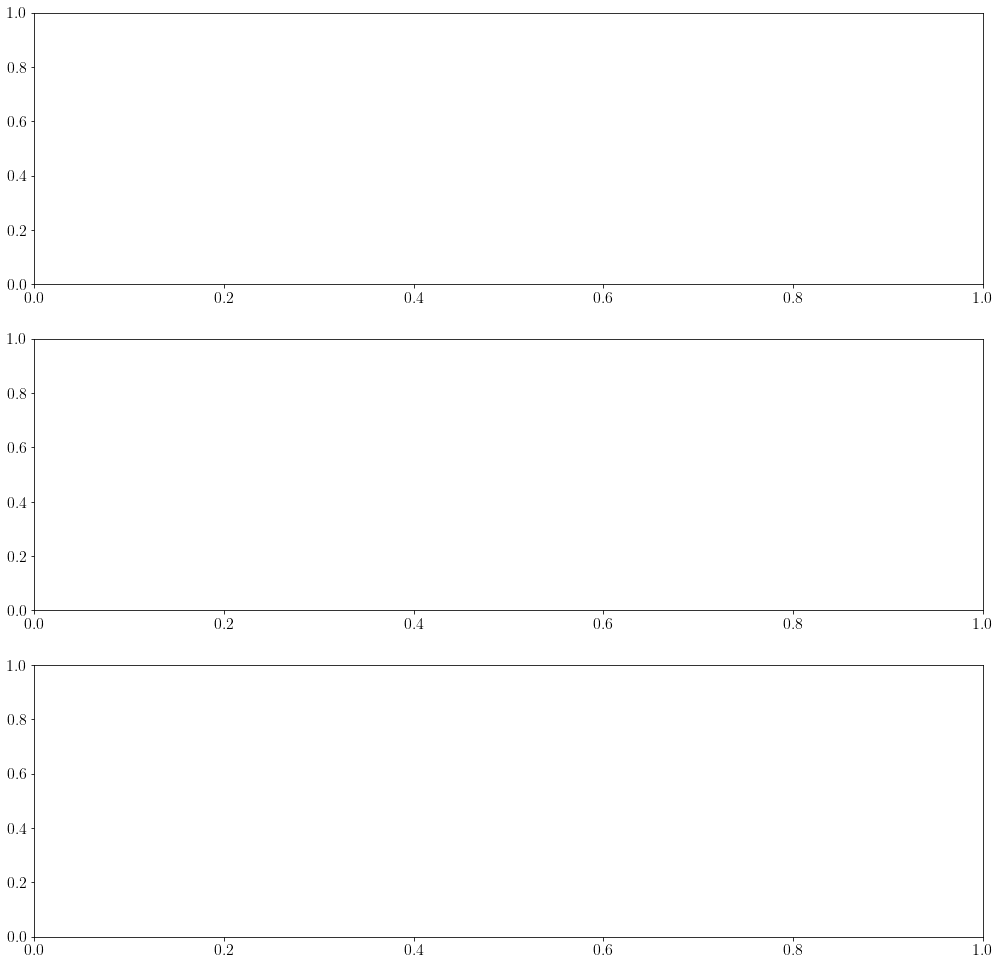

In [82]:
# Adjust fontsize
plt.rcParams['font.size'] = '16'

# Declare figure and subplots
fig, axes = plt.subplots(3, figsize=(17,17))

# Dict of the different data we wish to plot
dco_types = ['BBH', 'BHNS', 'BNS']
delay_time_lists = {'BBH': bbh_delay_times, 'BHNS': bhns_delay_times, 'BNS': bns_delay_times}

# Calculate the lines proportional to t^-1
x = np.linspace(1, 14000, num=100)
ys = {'BBH': 40000000*x**(-1), 'BHNS': 4000000*x**(-1), 'BNS': 800000*x**(-1)}

for index, dco_type in enumerate(dco_types):
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bbh_mask = np.logical_and.reduce((stype1 == 14, stype2 == 14))
            bbh_seeds = dco_seeds[bbh_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bbh_metallicities = dco_metallicities[bbh_mask]       # Initial metallicities for bbh objects
            bbh_hubble_times = hubble_times[bbh_mask]             # Get the hubble_time value for the bbh
            bbh_t_delays = t_delays[bbh_mask]                     # Get the delay times for the bbh
            
            # Mask for if the bbh merges in hubble time
            merged_mask = bbh_hubble_times == 1

            # Get the delay times and metallicities for the bbh that merge in hubble time
            bbh_delay_times = bbh_t_delays[merged_mask]
            bbh_merged_metallicities = bbh_metallicities[merged_mask]


            delay_time_bins = np.linspace(min(bbh_delay_times), max(bbh_delay_times), 20)
            np.histogram(bbh_delay_times, delay_time_bins)
            bns_formation_rates[alpha_val][beta_val]

    # Set y scale
    axes[index].set_yscale('log')

    # Make histogram of the delay times
    axes[index].hist(delay_time_lists[dco_type], bins=20, label='COMPAS', edgecolor='black')

    # Plot the lines proportional to t^-1
    axes[index].plot(x, ys[dco_type], color='black', label=r'$\propto t^{-1}$')
    axes[index].set(ylabel=r'd$\mathcal{R}_{\textrm{form}}$/dt [Gyr$^{-1}$Myr$^{-1}$]')
    
    # Add box with label to indicate which DCO type we are plotting in the top left of each panel   
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axes[index].annotate(r'%s'%(dco_type), xy=(0.5, .95), xycoords='axes fraction', fontsize = 20, weight = 'bold', ha='center', va="top",bbox=bbox_props)

# Add legend to the top panel
axes[0].legend(loc='upper right', prop={'size': 15})

# Set y limits for each plot
axes[0].set_ylim(1, 10**5.5)
axes[1].set_ylim(1, 10**4.5)
axes[2].set_ylim(1, 10**3.5)

# Make the x label for the plots
plt.xlabel(r't$_{\textrm{delay}}$ [Gyrs]', fontsize=17)

# Show the plot!
plt.show()

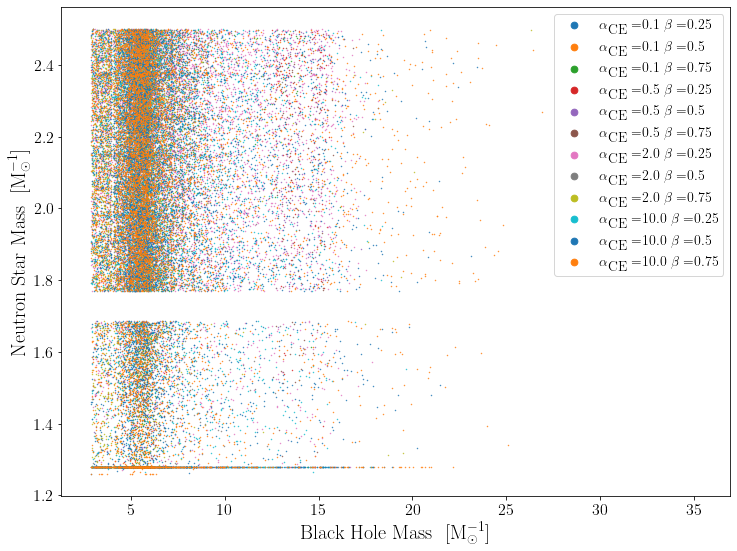

In [83]:
def plot_bhVSns_masses(data, alpha_vals, beta_vals):
    """
    This function plots the masses of black holes and neutron stars for BHNS mergers in given data. It will iterate over given
    alpha_CE and beta values and plot the masses for each BHNS run's results.

    ...

    Parameters
    ----------
    data : dict
        a two-dimensional dictionary containing the corresponding compas objects for each of the alpha/beta values

    alpha_vals : list
        a one dimensional list containing the alpha_CE values corresponding to the keys of the data dictionary
    
    beta_vals: list 
        a one dimensional list containing the beta values corresponding to the keys of the data dictionary's first dimension

    """

    # Declar figure
    plt.figure(figsize=(12, 9))

    # Iterate over given alpha_CE and beta values
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            model_data = data[alpha_val][beta_val] # the data

            # Get the important BSE values
            stellar_type_1, stellar_type_2, hubble_flag, mass_1, mass_2 = \
                        model_data.get_COMPAS_variables("BSE_Double_Compact_Objects", ["Stellar_Type(1)", "Stellar_Type(2)", "Merges_Hubble_Time", "Mass(1)", "Mass(2)"])
            
            # Mask for BHNS systems
            bhns_mask = np.logical_or(np.logical_and(stellar_type_1 == 13, stellar_type_2==14), np.logical_and(stellar_type_1 == 14, stellar_type_2==13))
            
            # Get the data for BHNS systems only
            stellar_type_1, stellar_type_2, hubble_flag, mass_1, mass_2 = \
                        stellar_type_1[bhns_mask], stellar_type_2[bhns_mask], hubble_flag[bhns_mask], mass_1[bhns_mask], mass_2[bhns_mask]

            # Flags for the neutron stars
            ns1_flag = np.logical_and(stellar_type_1 == 13, hubble_flag==1)     # primary
            ns2_flag = np.logical_and(stellar_type_2 == 13, hubble_flag==1)     # secondary

            # Get the masses
            ns1_mass = mass_1[ns1_flag]                                         # primary
            ns2_mass = mass_2[ns2_flag]                                         # secondary

            # Combine to get the entire list of neutron star masses
            ns_mass = np.concatenate((ns1_mass, ns2_mass), axis=0)

            # Flags for black holes
            bh1_flag = np.logical_and(stellar_type_1 == 14, hubble_flag==1)     # primary
            bh2_flag = np.logical_and(stellar_type_2 == 14, hubble_flag==1)     # secondary

            # Get the masses 
            bh1_mass = mass_1[bh1_flag]                                         # primary
            bh2_mass = mass_2[bh2_flag]                                         # secondary

            # Combine to get the entire list of black hole masses
            bh_mass = np.concatenate((bh1_mass, bh2_mass), axis=0)

            # Plot the data
            plt.scatter(bh_mass, ns_mass, s=0.2, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

    # Label axes
    plt.xlabel(r'Black Hole Mass$   \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=20)
    plt.ylabel(r'Neutron Star Mass$   \ \  [\rm{M}_{\odot}^{-1}]$', fontsize=20)

    # Include legend
    plt.legend(loc='upper right',  prop={'size': 14},  markerscale=15)

    # Adjust tick fontsize
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Display the plot
    plt.show()

plot_bhVSns_masses(data, alpha_vals, beta_vals)